Given Dataset: NYC Taxi Trip Duration

# Objective:
Build a model that predicts the total ride duration of taxi trips in New York City.

# Data fields
● id - a unique identifier for each trip  
● vendor_id - a code indicating the provider associated with the trip record  
● pickup_datetime - date and time when the meter was engaged  
● dropoff_datetime - date and time when the meter was disengaged  
● passenger_count - the number of passengers in the vehicle (driver entered value)        
● pickup_longitude - the longitude where the meter was engaged  
● pickup_latitude - the latitude where the meter was engaged    
● dropoff_longitude - the longitude where the meter was disengaged    
● dropoff_latitude - the latitude where the meter was disengaged    
● store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip  
● trip_duration - duration of the trip in seconds

In [1]:
#Importing Python Packages
import numpy as np
import scipy as sp
import pandas as pd
import statsmodels
#import pandas_profiling
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import haversine as haversine

import datetime

In [2]:
#importing dataset
#We have two data sets: Training Dataset and Test Dataset
#defining local default path
your_local_path="C:\Program Files (x86)\Python36-32/"
df_train=pd.read_csv(your_local_path+'train_taxi.csv')
df_test=pd.read_csv(your_local_path+'test.csv')

Test Dataset contains 9 columns, missing columns are dropoff_datetime and trip_duration.

In [3]:
df_train.shape

(1458644, 11)

In [4]:
df_test.shape

(625134, 9)

# Understanding Dataset

In [5]:
df_train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [6]:
df_test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [7]:
df_train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


We can see that trip duration has 75% values are around 1.075000e+03 and max value is 3.526282e+06 . This shows some outliers which we need to remove.

In [8]:
#Missing Values
df_train.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [9]:
df_test.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
dtype: int64

In [10]:
#We need to check for any duplicate data by comparing the IDs column in both train and test dataset
print('No. of records in Train dataset',df_train.shape[0])
print("Unique records",len(pd.unique(df_train["id"])))
print('No. of records in Test dataset',df_test.shape[0])

print("Unique records",len(pd.unique(df_test["id"])))

No. of records in Train dataset 1458644
Unique records 1458644
No. of records in Test dataset 625134
Unique records 625134


# Outliers
We will Work to remove the Outliers In Trip Duration

In [11]:
#Add one more column for hourly duration
df_train['Hour_duration']=df_train['trip_duration']/3600
df_train.Hour_duration.describe()

count    1.458644e+06
mean     2.665256e-01
std      1.454842e+00
min      2.777778e-04
25%      1.102778e-01
50%      1.838889e-01
75%      2.986111e-01
max      9.795228e+02
Name: Hour_duration, dtype: float64

In [12]:
df_train.head(7)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,Hour_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,0.126389
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,0.184167
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,0.590000
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,0.119167
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,0.120833
5,id0801584,2,2016-01-30 22:01:40,2016-01-30 22:09:03,6,-73.982857,40.742195,-73.992081,40.749184,N,443,0.123056
6,id1813257,1,2016-06-17 22:34:59,2016-06-17 22:40:40,4,-73.969017,40.757839,-73.957405,40.765896,N,341,0.094722


In [13]:
# we will see how many instances are having more trip_duration
print(len(df_train.loc[df_train['Hour_duration']>3]))

2112


In [14]:
# We will remove the cases where Hour_duration>3
df_train=df_train.loc[df_train['Hour_duration']<=3,[str(i) for i in df_train.columns]]

In [15]:
df_train.shape

(1456532, 12)

# Plotting the distribution

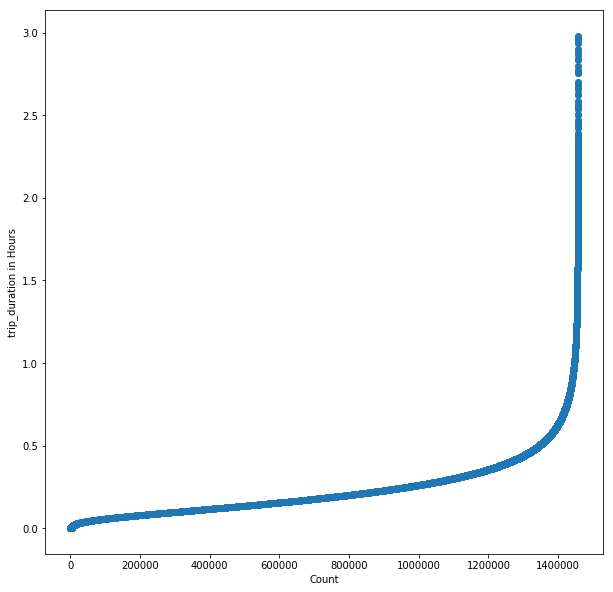

In [16]:
#plotting the scatter plot for trip duration to see the distribution
plt.figure(figsize=(10,10))
plt.scatter(range(len(df_train["Hour_duration"])), np.sort(df_train["Hour_duration"]))
plt.xlabel('Count')
plt.ylabel('trip_duration in Hours')
plt.show()

#Calculating the distance between two points

In [17]:
from haversine import haversine
#It calculates the distance between two points over a sphere
def calculate_distance(var):
    return haversine((var["pickup_latitude"], var["pickup_longitude"]), 
                     (var["dropoff_latitude"], var["dropoff_longitude"]), miles = True)

df_train["haversine_distance"] = df_train.apply(lambda x: calculate_distance(x), axis=1)


Adding the distance column to the dataset

In [18]:
df_test["haversine_distance"] = df_test.apply(lambda x: calculate_distance(x), axis=1)
df_train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,Hour_duration,haversine_distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,0.126389,0.931137
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,0.184167,1.121890
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,0.590000,3.967515
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,0.119167,0.923046
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,0.120833,0.738554


# Features Extraction from Datetime column

In [19]:
df_train['datetime']=pd.to_datetime(df_train['pickup_datetime'])
df_train['hour_pick']=df_train.datetime.dt.hour
df_train['day_of_week']=df_train.datetime.dt.dayofweek
df_train['day_of_month']=df_train.datetime.dt.day
df_train['month']=df_train.datetime.dt.month

In [20]:
df_test['datetime']=pd.to_datetime(df_test['pickup_datetime'])
df_test['hour_pick']=df_test.datetime.dt.hour
df_test['day_of_week']=df_test.datetime.dt.dayofweek
df_test['day_of_month']=df_test.datetime.dt.day
df_test['month']=df_test.datetime.dt.month

We will analyse the regression plot for trip duration vs distance , first with all the data and later with limited data 

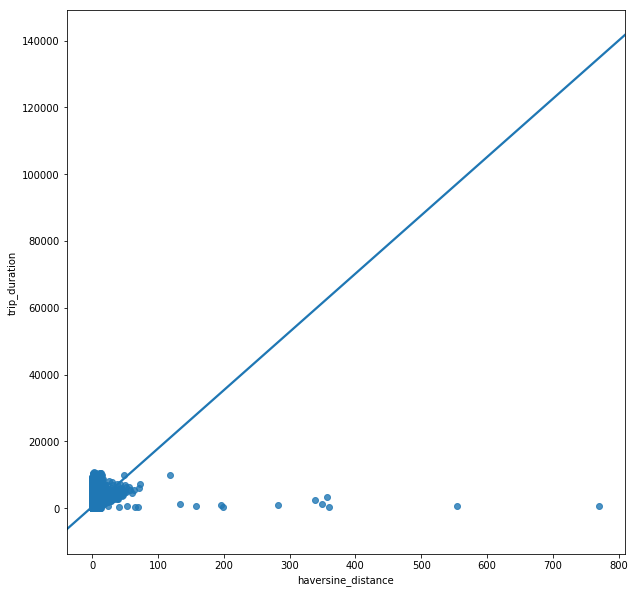

In [21]:
plt.figure(figsize=(10,10))
sns.regplot(x="haversine_distance", y="trip_duration", data=df_train,ci=None)
plt.show()

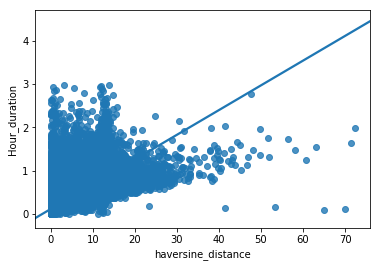

In [22]:
#try to plot after removing the outliers
sns.regplot(x="haversine_distance", y="Hour_duration", data=df_train[df_train["haversine_distance"] < 100])

We can see data is mostly scattered, so linear model will not give correct predictions.


# Build the Model

In [23]:
#separating the features and target

x=df_train.drop(['id','trip_duration','store_and_fwd_flag','dropoff_datetime','pickup_datetime','datetime','Hour_duration'],1)
y=df_train.trip_duration

In [24]:
x.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,haversine_distance,hour_pick,day_of_week,day_of_month,month
0,2,1,-73.982155,40.767937,-73.964630,40.765602,0.931137,17,0,14,3
1,1,1,-73.980415,40.738564,-73.999481,40.731152,1.121890,0,6,12,6
2,2,1,-73.979027,40.763939,-74.005333,40.710087,3.967515,11,1,19,1
3,2,1,-74.010040,40.719971,-74.012268,40.706718,0.923046,19,2,6,4
4,2,1,-73.973053,40.793209,-73.972923,40.782520,0.738554,13,5,26,3


In [25]:

x_test=df_test.drop(['id','store_and_fwd_flag','pickup_datetime','datetime'],1)
x_test.shape

(625134, 11)

#Standardize the data

In [26]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_std = scaler.fit_transform(x)
X_std_tst=scaler.fit_transform(x_test)

In [27]:
X_std


array([[ 0.93361742, -0.50543101, -0.12218895, ..., -1.56086667,
        -0.17280287, -0.30741091],
       [-1.07110255, -0.50543101, -0.09765832, ...,  1.50971463,
        -0.4026105 ,  1.47721068],
       [ 0.93361742, -0.50543101, -0.07807686, ..., -1.04910312,
         0.40171622, -1.49715864],
       ..., 
       [ 0.93361742, -0.50543101,  0.20251908, ...,  0.48618753,
         0.74642767,  0.28746296],
       [-1.07110255, -0.50543101, -0.12111304, ..., -1.04910312,
        -1.20693721, -1.49715864],
       [-1.07110255, -0.50543101, -0.08528542, ..., -1.04910312,
        -1.20693721,  0.28746296]])

Building the model with RandomForest Regressor

In [28]:
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestRegressor
model_rnd_frst=RandomForestRegressor(n_estimators=10, criterion='mse', max_depth=None, 
                                     min_samples_split=4, min_samples_leaf=1, 
                                     min_weight_fraction_leaf=0.0, max_features='auto', 
                                     max_leaf_nodes=None, min_impurity_split=1e-07, 
                                     bootstrap=True, oob_score=False, n_jobs=-1, 
                                     random_state=None, verbose=1, warm_start=False)
print(cross_val_score(model_rnd_frst,x,y,cv=5))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: Deprecation

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\ProgramData\Anaconda3

[ 0.7795104   0.78097702  0.78287251  0.78313719  0.78345085]


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    1.3s finished


In [29]:
#Fitting the model
model_rnd_frst.fit(X_std, y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\ProgramData\Anaconda3

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=4,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

Predicting the Duration for Test Data

In [30]:
y_pred_tst=model_rnd_frst.predict(X_std_tst)

[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    1.9s finished


In [31]:
y_pred_tst

array([  698.43666667,   540.19      ,   432.125     , ...,  1370.28333333,
        1918.94166667,  1134.2       ])

In [34]:
Output=pd.DataFrame(df_test.id)
Output['Duration']=pd.DataFrame(y_pred_tst)

In [36]:
Output.head()

,id,Duration
0,id3004672,698.436667
1,id3505355,540.190000
2,id1217141,432.125000
3,id2150126,1176.451667
4,id1598245,315.953333


In [37]:
Output.to_csv('Output.csv', index=False)